<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=25% ALIGN="right">
</figure>

<p><div> 
<br><b>Probabilistic Design</b>
<br><b>CEGM2XXX</b>
<br> <i>This course is given at the faculty of Civil Engineering and Geosciences at the Technical University of Delft</i>
<br><b>Teaching team:</b>
<br><i>- Dr. Ir. R.C.Lanzafame </i>
<br><i>- Dr. P.M. Nasarre</i>
</div>
<br>
<br><b>Notebooks created by teaching assistant:</b>
<br><i>- Siemen Algra</i>
</div>

### Case study: Component Reliability Analysis
#### Floating and submerged tunnel, crossing the strait of Gibraltar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve # for plotting the LSF

import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import numpy as np
import scipy.linalg as scp
import matplotlib.pylab as plt
import time

import sympy as sp
import scipy

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6




### 1. Load FEM model in

Height of the beam: 23.8 m
Width of the beam: 9.2 m
Area of the beam: 38 m2
E-modulus of the beam: 50000000000.0 Pa
Torsion constant of the beam: 50653.54804769255 m4
Shear modulus of the beam: 19230769230.76923 Pa
Density of the beam: 2500 kg/m3

Mass per unit length of the beam: 150000 kg/m
Bending stiffness of the beam, x-direction : 4870556483768264.0 N.m2
Bending stiffness of the beam, z-direction: 727780348820962.1 N.m2
Axial stiffness of the beam: 1900000000000.0 N
Torsional stiffness of the beam: 974106693224856.8 N.m2
Moment of inertia of the beam: 126633870.11923137 m2


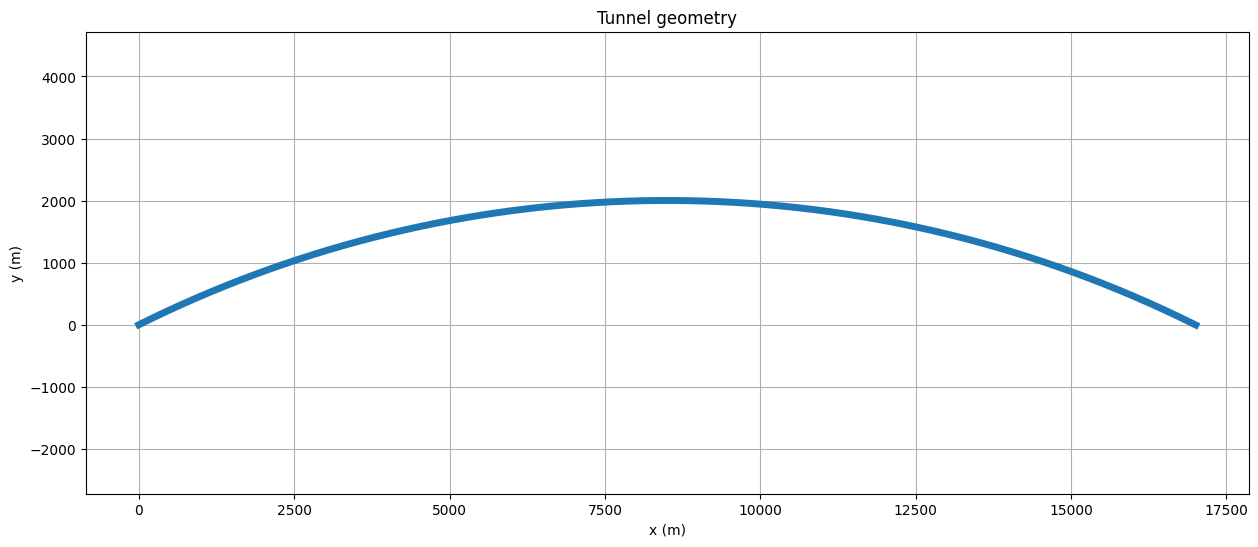

In [2]:
# Import local classes
import sys
sys.path.append(r'../../src/')

# Obtain function that calculates the stress
from component_reliability.Case_Study_Compontent_Reliability_Tools import calculate_stress_FEM
# Function takes external forces as input and returns the stress

### 2. Determine statistical properties of Random Variables

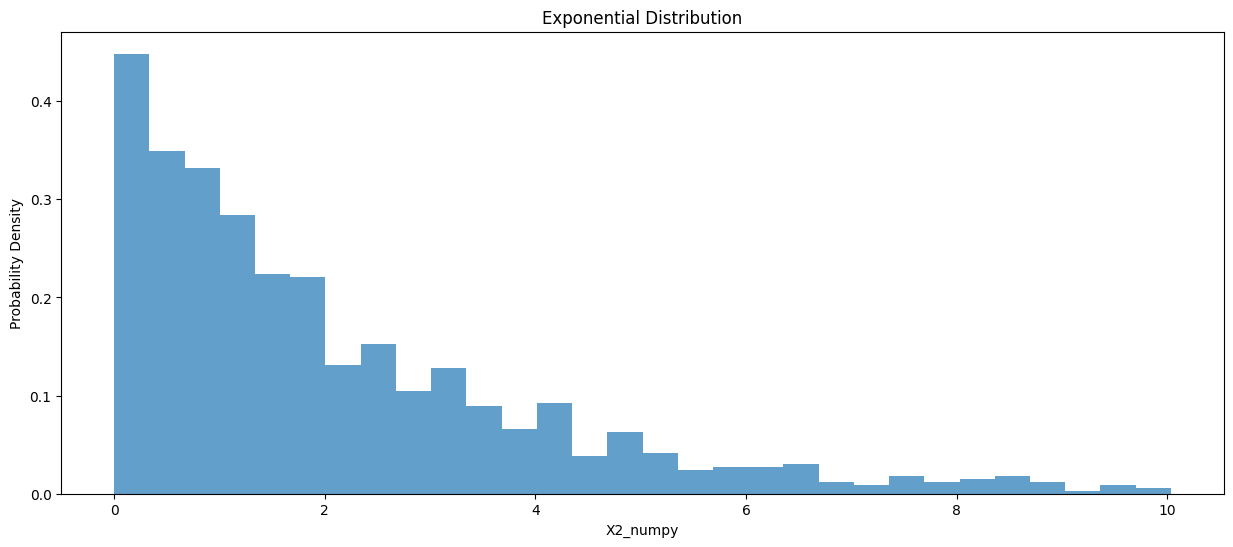

In [3]:
import numpy as np
# Determine the random variables 
X1 = ot.Exponential(2.0309)   # Significant wave height, swell waves
X2 = ot.Exponential(2.0663)   # Significant wave height, wind sea waves
X3 = ot.Normal(2, 0.2)        # Velocity of current

import matplotlib.pyplot as plt

# Define the exponential distribution
X2_numpy = np.random.exponential(scale=2.0309, size=1000)

# Plot the distribution
plt.hist(X2_numpy, bins=30, density=True, alpha=0.7)
plt.xlabel('X2_numpy')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution')
plt.show()


### 3. Define external forces depending on the random variables
Using the **Morison equation**

In [4]:
def F_morison_swell_current(significant_wave_height_swell, U_current_veloctiy):
    # General properties
    rhoW = 1025                                                 # kg/m^3
    D = np.sqrt(38/np.pi)*2                                     # diameter of cylinder
    depth = 30                                                  # depth of water

    # Swell Wave properties
    Tp = 12
    Omega = 2*np.pi/Tp
    L = 9.81*Tp**2/(2*np.pi)
    k = 2*np.pi/L
    Amplitude = significant_wave_height_swell/2                 # wave amplitude

    
    # Water velocity
    cos_func = 1 #np.cos(omega*t-k*x)
    u_swell =  Amplitude*Omega*np.exp(-k*depth)*cos_func
    
    # Intertia force
    CM = 1+((9.2/2) / (20.8/2))                                 # added mass coefficient
    F_inertia_swell =  (np.pi*rhoW*CM*D**2)/4 * (u_swell)
    
    # Drag force
    CD = 0.13 # drag coefficient
    F_drag_swell = 0.5*rhoW*CD*D*(u_swell+U_current_veloctiy)**2
    
    F_combined_swell_current = np.sqrt(F_inertia_swell**2 + F_drag_swell**2)
    
    return F_combined_swell_current


In [5]:
def F_morison_wind(significant_wave_height_windsea):
    # General properties
    rhoW = 1025                                                 # kg/m^3
    D = np.sqrt(38/np.pi)*2                                     # diameter of cylinder
    depth = 30                                                  # depth of water

    # Wind sea Wave properties
    Tp = 12
    Omega = 2*np.pi/Tp
    L = 9.81*Tp**2/(2*np.pi)
    k = 2*np.pi/L
    Amplitude = significant_wave_height_windsea/2                 # wave amplitude

    
    # Water velocity
    cos_func = 1 #np.cos(omega*t-k*x)
    u_wind =  Amplitude*Omega*np.exp(-k*depth)*cos_func
    
    # Intertia force
    CM = 1+((9.2/2) / (20.8/2))                                 # added mass coefficient
    F_inertia_wind =  (np.pi*rhoW*CM*D**2)/4 * (u_wind)
    
    # Drag force
    CD = 0.13 # drag coefficient
    F_drag_wind = 0.5*rhoW*CD*D*(u_wind)**2
    
    F_combined_wind = np.sqrt(F_inertia_wind**2 + F_drag_wind**2)
    
    return F_combined_wind

### 4. Define function to calculate total stress

In [6]:
def total_stress(significant_wave_height_swell, significant_wave_height_windsea, U_current_velocity):
    
    # Calculate stress using FEM
    sigma_wind = calculate_stress_FEM(F_morison_wind(significant_wave_height_windsea))
    sigma_swell = calculate_stress_FEM(F_morison_swell_current(significant_wave_height_swell, U_current_velocity))
    
    # Total stress
    sigma = sigma_wind + sigma_swell 
    return sigma   

### 5. Determine Limit State Function

In [7]:
# Determine myLSF
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[X1, X2, X3]. 
    '''
    
    
    # Maximum stress in concrete
    sigma_max = 75
    g = [sigma_max - np.max(np.abs(total_stress(x[0], x[1], x[2])))]
    # print(np.shape(g))
    return g

### 6. Run Monte Carlo Simulation and FORM analysis
*Depending on the monte carlo sample size, can take quite some time to run (hours)*

In [8]:
from component_reliability.Case_Study_Compontent_Reliability_Tools import run_FORM_and_MCS
from component_reliability.Case_Study_Compontent_Reliability_Tools import run_FORM_and_MCS_part2

In [9]:
run_FORM_and_MCS(X1, X2, X3, myLSF, mc_size = 10)

FORM result, pf = 0.1847
FORM result, beta = 0.897

The design point in the u space:  [0.594081,0.672079,0.0294709]
The design point in the x space:  [0.633476,0.669425,2.00589]
pf for MCS:  0.3


The importance factors [windsea : 0.438158, swell : 0.560763, u_current : 0.00107826]


In [10]:
run_FORM_and_MCS_part2()

---------------Running part 2 of FORM and MCS-------------------
The importance factors as defined in the textbook are:  [0.661935,0.748841,0.0328369]
The sensitivity factors of the reliability index with regards to the distribution parameters are:

[lambda_marginal_0 : 0.346363, gamma_marginal_0 : -1.11043]
[lambda_marginal_1 : 0.394951, gamma_marginal_1 : -1.21909]
[mu_0_marginal_2 : -0.164268, sigma_0_marginal_2 : -0.00484113]
[R_2_1_copula : 0, R_3_1_copula : 0, R_3_2_copula : 0]
